<a href="https://colab.research.google.com/github/faizankshaikh/HomMul/blob/main/experiments/trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with Self-Playing Deep Reinforcement Learning


## Initializing the game

In [1]:
#@title Required installation
# !pip install -q black gymnasium pettingzoo==1.22.3 tianshou
# !git clone https://github.com/faizankshaikh/HomMul.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 10.6 MB/s eta 0:00:00
Cloning into 'HomMul'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 97 (delta 30), reused 45 (delta 12), pack-reused 0
Unpacking objects: 100% (97/97), 3.93 MiB | 9.11 MiB/s, done.


In [1]:
#@title Change working path
%cd HomMul/

/content/HomMul


In [2]:
#@title Import libraries and modules
%load_ext tensorboard

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler

from hommul.envs.hommul_v0 import HomMul

from torch.optim import Adam

from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.utils import TensorboardLogger
from tianshou.trainer import offpolicy_trainer
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv, PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager

from pettingzoo.utils import parallel_to_aec

from torch.utils.tensorboard import SummaryWriter

In [3]:
#@title Setup Gymnasium environment
env = HomMul()
original_env = HomMul(render_mode="human")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#@title Example of gameplay
episodes = 2

for episode in range(episodes):
    print(f"Episode #{episode+1}")
    print("=" * 10)
    obs = original_env.reset()
    print()

    while original_env.agents:
        acts = {
            "player1": np.random.choice([0, 1]),
            "player2": np.random.choice([0, 1])
        }
        print(f"--Action taken by player 1: {original_env.action_dict[acts['player1']]}")
        print(f"--Action taken by player 2: {original_env.action_dict[acts['player2']]}")
        print()

        obs, rews, terms, truncs, infos = original_env.step(acts)
        print()

Episode #1
--Days left: 1
--Current life of agent 1: 2
--Current life of agent 2: 2
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2

--Action taken by player 1: wait
--Action taken by player 2: play

--Days left: 0
--Current life of agent 1: 1
--Current life of agent 2: 0
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4
--Previous action of agent 1: wait
--Previous action of agent 2: play

Episode #2
--Days left: 2
--Current life of agent 1: 3
--Current life of agent 2: 2
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4

--Action taken by player 1: play
--Action taken by player 2: wait

--Days left: 1
--Current life of agent 1: 3
--Current life of agent 2: 1
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2
--Previous action of agent 1: play
--Previous action of agent 2: wait

--Action taken by player 1: play
--Action taken by player 2: play

--Days left: 

## Heuristics Benchmarking


death rate (in %) of player1: 40.8 +- 8.225
death rate (in %) of player2: 36.4 +- 5.573


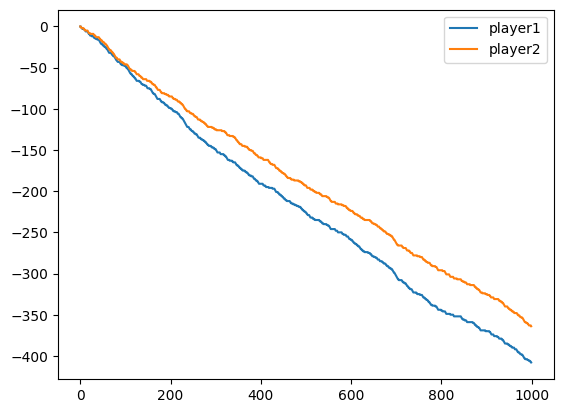

In [5]:
#@title Case - both always play
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)

interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")

plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 62.9 +- 5.033
death rate (in %) of player2: 42.7 +- 7.303


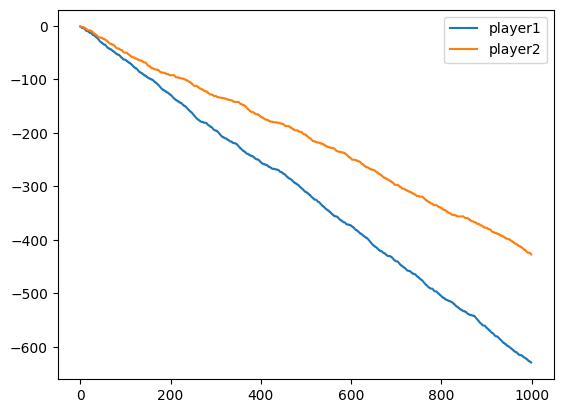

In [6]:
#@title Case - both always wait
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 63.1 +- 7.244
death rate (in %) of player2: 57.7 +- 6.218


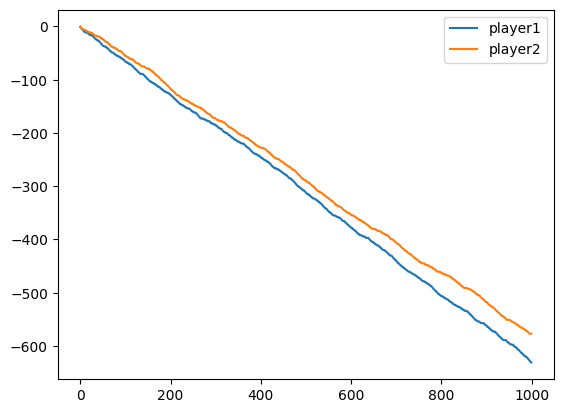

In [7]:
#@title Case - player1 waits, player2 plays
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 66.3 +- 6.088
death rate (in %) of player2: 43.3 +- 4.110


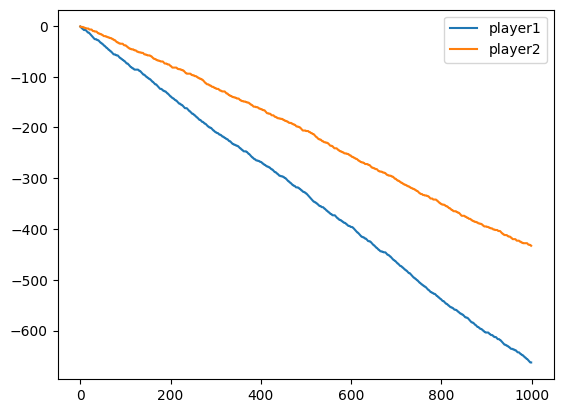

In [8]:
#@title Case - player1 plays, player2 waits
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 48.7 +- 5.287
death rate (in %) of player2: 36.5 +- 6.074


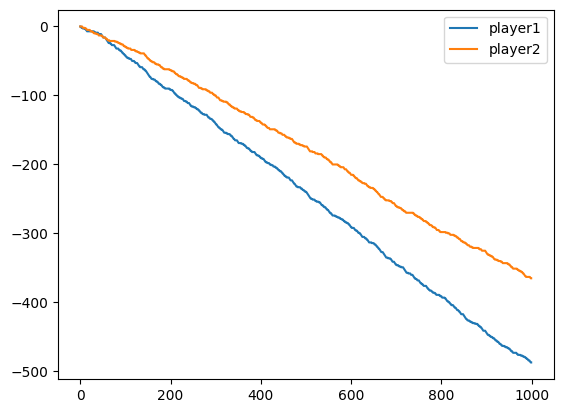

In [9]:
#@title Case - Always play vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 64.0 +- 6.094
death rate (in %) of player2: 50.9 +- 6.511


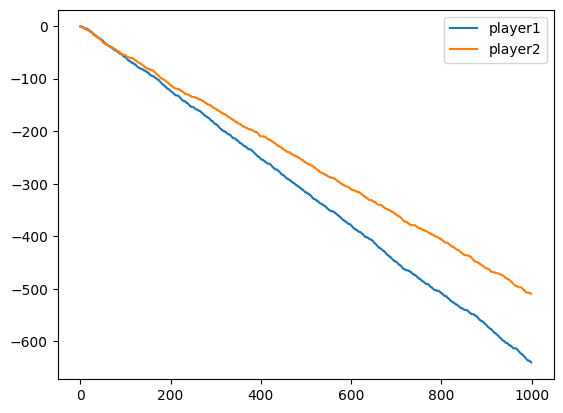

In [10]:
#@title Case - Always wait vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 55.9 +- 6.429
death rate (in %) of player2: 21.8 +- 7.395


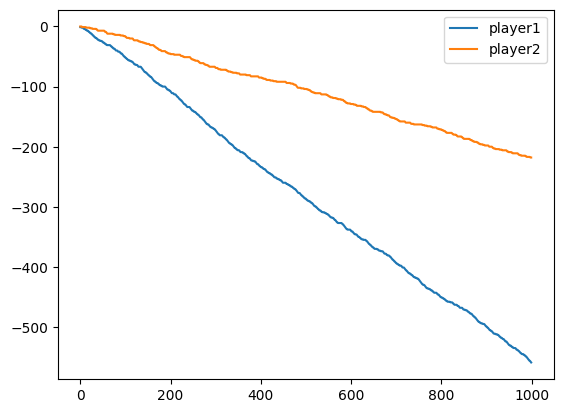

In [11]:
#@title Case - Always play vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 63.6 +- 6.220
death rate (in %) of player2: 31.7 +- 6.460


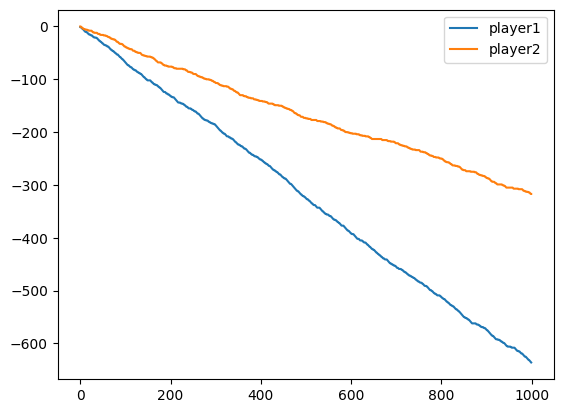

In [12]:
#@title Case - Always wait vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [13]:
#@title Load optimal policy

def optimal(obs):
    df = pd.read_csv("models/optimal_policy.csv")
    return df.loc[
        (df["days_left"] == obs["player1"]["observation"][0][0]) &
        (df["player1_life_points"] == obs["player1"]["observation"][0][1]) &
        (df["player2_life_points"] == obs["player1"]["observation"][0][2]) &
        (df["player1_prob_payoff"] == obs["player1"]["observation"][0][3])
    ]["action"].values[0] - 1

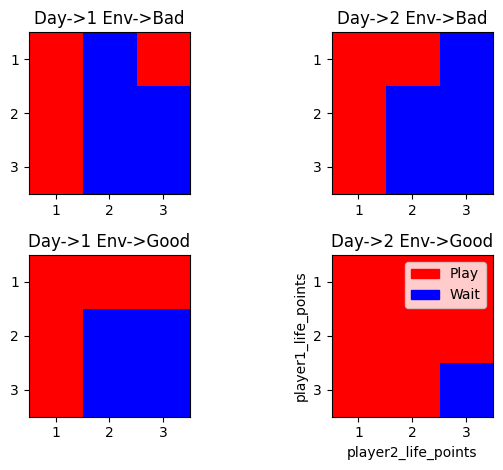

In [14]:
#@title Visualize optimal policy

df = pd.read_csv("models/optimal_policy.csv")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

arr = df.loc[(df["days_left"] == 1) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] < 0.3), "action"].values

ax1.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
ax1.set_title("Day->1 Env->Bad")
ax1.set_xticks([0, 1, 2], [1, 2, 3])
ax1.set_yticks([0, 1, 2], [1, 2, 3])

arr = df.loc[(df["days_left"] == 2) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] < 0.3), "action"].values

ax2.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
ax2.set_title("Day->2 Env->Bad")
ax2.set_xticks([0, 1, 2], [1, 2, 3])
ax2.set_yticks([0, 1, 2], [1, 2, 3])

arr = df.loc[(df["days_left"] == 1) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] > 0.3), "action"].values

ax3.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
ax3.set_title("Day->1 Env->Good")
ax3.set_xticks([0, 1, 2], [1, 2, 3])
ax3.set_yticks([0, 1, 2], [1, 2, 3])

arr = df.loc[(df["days_left"] == 2) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] > 0.3), "action"].values

ax = ax4.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
ax4.set_title("Day->2 Env->Good")
ax4.set_xticks([0, 1, 2], [1, 2, 3])
ax4.set_yticks([0, 1, 2], [1, 2, 3])
ax4.set_xlabel("player2_life_points")
ax4.set_ylabel("player1_life_points")

red_patch = mpatches.Patch(color='red', label='Play')
blue_patch = mpatches.Patch(color='blue', label='Wait')

plt.legend(handles=[red_patch, blue_patch])

fig.tight_layout()
plt.show()

death rate (in %) of player1: 52.8 +- 7.833
death rate (in %) of player2: 44.4 +- 3.871


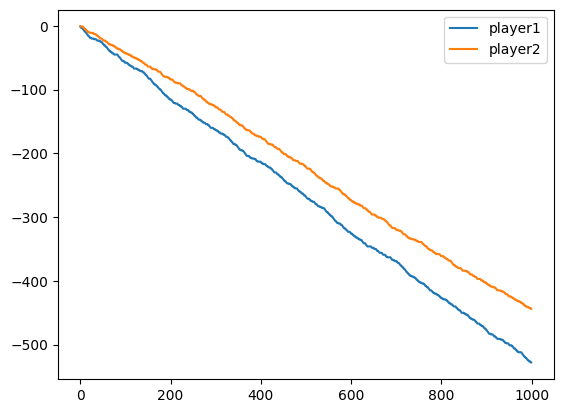

In [15]:
#@title Case - optimal vs Always wait
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": optimal(obs),
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate (in %) of player1: 53.0 +- 6.166
death rate (in %) of player2: 42.1 +- 7.622


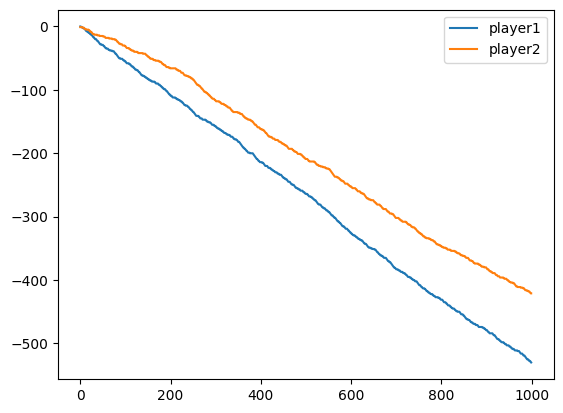

In [16]:
#@title Case - optimal vs Always play
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": optimal(obs), 
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate (in %) of player1: 43.3 +- 9.944
death rate (in %) of player2: 21.1 +- 5.356


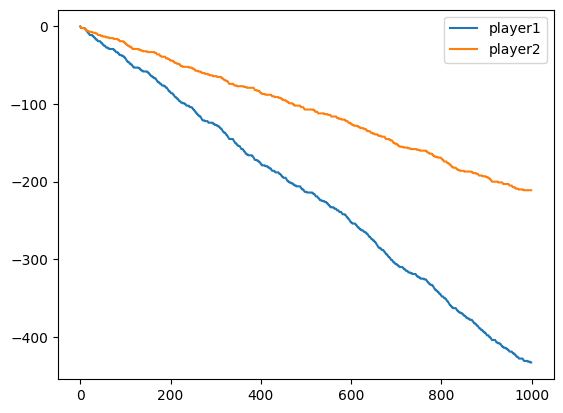

In [17]:
#@title Case - optimal vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": optimal(obs),
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate (in %) of player1: 32.3 +- 5.249
death rate (in %) of player2: 19.6 +- 5.573


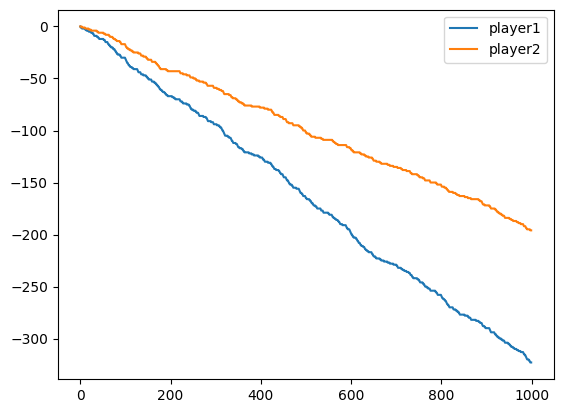

In [18]:
#@title Case - optimal vs optimal
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": optimal(obs),
            "player2": optimal(obs)
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

## Deep RL training


In [19]:
#@title Define heuristic algos in Tianshou
## agent that always plays
class AlwaysPlay(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)
    
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 1] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that always waits
class AlwaysWait(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that waits for low health to play
class HailMary(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        for i in range(mask.shape[0]):
            if obs[i, :, 2] <= 1:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## optimal agent 
class OptimalPolicy(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        df = pd.read_csv("models/optimal_policy.csv")

        for i in range(mask.shape[0]):
            action = df.loc[
                (df["days_left"] == obs[i, :, 0][0]) &
                (df["player1_life_points"] == obs[i, :, 1][0]) &
                (df["player2_life_points"] == obs[i, :, 2][0]) &
                (df["player1_prob_payoff"] == obs[i, :, 3][0])
            ]["action"].values[0] - 1
            if action:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## random agent
class RandomAgent(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, np.random.choice([0, 1])] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
#@title Prerequisites for training
# Step 2: Wrap the environment for Tianshou interfacing
def _get_env_train():
    env = HomMul(include_all_states=True)
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

def _get_env_test():
    env = HomMul()
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

# seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

env = HomMul()
agents =  env.agents[:]

# Step 3: Define policies for each agent
## learning agent
def _get_agent(pretrained=False):
    vec_env = _get_env_train()
    net = Net(
        state_shape=vec_env.observation_space.shape,
        action_shape=vec_env.action_space.n,
        hidden_sizes=[128, 128],
        device="cuda",
    ).to("cuda")
    optim = Adam(net.parameters(), lr=1e-4)
    model = DQNPolicy(
        model=net,
        optim=optim,
        discount_factor=0.9,
        estimation_step=3,
        target_update_freq=50,
    )

    if pretrained:
        model_save_path = os.path.join("models", "vs_hail_mary.pth")
        model.load_state_dict(torch.load(model_save_path))
    return model

agent_learn1 = _get_agent(pretrained=True)
agent_learn2 = _get_agent(pretrained=True)

train_policies = MultiAgentPolicyManager([agent_learn1, agent_learn2],  _get_env_train())

train_envs = DummyVectorEnv([_get_env_train for _ in range(5)])
test_envs = DummyVectorEnv([_get_env_test for _ in range(2)])
train_envs.seed(seed)
test_envs.seed(seed)

# Step 4: Collector setup
train_collector = Collector(
    train_policies,
    train_envs,
    VectorReplayBuffer(2_000, len(train_envs)),
    exploration_noise=True,
)

test_policies = MultiAgentPolicyManager([OptimalPolicy(), agent_learn2],  _get_env_test())
test_collector = Collector(test_policies, test_envs, exploration_noise=True)

train_collector.collect(n_step=50)

def save_best_fn(policy):
    model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    os.makedirs(os.path.join("log", "hommul", "dqn"), exist_ok=True)
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        torch.save(train_policies.policies[agents[0]].state_dict(), model_save_path1)
    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        torch.save(train_policies.policies[agents[1]].state_dict(), model_save_path2)

def stop_fn(mean_rewards):
    return mean_rewards >= -0.05

def train_fn(epoch, env_step):
    # freeze training for player1
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].set_eps(0.05)

    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        train_policies.policies[agents[1]].set_eps(0.1)

def test_fn(epoch, env_step):
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].set_eps(0.05)

    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        train_policies.policies[agents[1]].set_eps(0.05)

def reward_metric(rews):
    return rews[:, 1]

In [21]:
#@title Clear logs and setup TensorBoard
!rm -rf /content/HomMul/log

log_path = os.path.join("log", "hommul", "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

##########

death rate (in %) of player1: 34.8 +- 7.992
death rate (in %) of player2: 20.0 +- 6.214


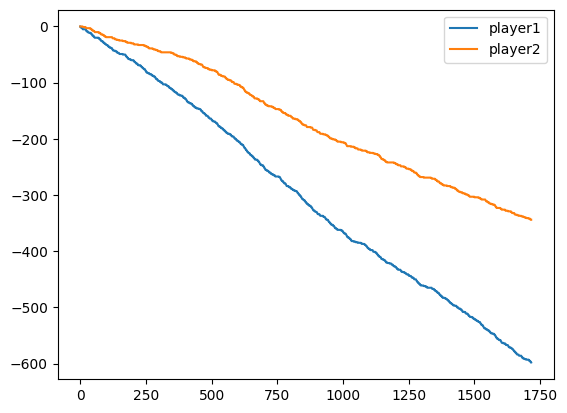

In [23]:
#@title Training
for evolution in range(10):
    print(f"#### Evolution {evolution+1}")
    result = offpolicy_trainer(
        policy=train_policies,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=20,
        step_per_epoch=1000,
        step_per_collect=50,
        episode_per_test=1000,
        batch_size=512,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=0.1,
        test_in_train=False,
        reward_metric=reward_metric,
        logger=logger
    )

    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].load_state_dict(torch.load(model_save_path2))
        train_policies.policies[agents[1]].load_state_dict(torch.load(model_save_path2))

    result = test_collector.collect(n_step=5000)
    arr = result["rews"]
    interval_size = 100
    num_intervals = episodes // interval_size

    means = []
    std_devs = []

    for i in range(0, episodes, interval_size):
        interval_data = arr[i:i+interval_size]
        mean = np.mean(interval_data, axis=0)
        means.append(mean)

    for i in range(num_intervals - 1):
        mean_diff = means[i+1] - means[i]
        std_devs.append(mean_diff)

    avg = (np.mean(arr, axis=0)) * -100
    std_dev = np.std(std_devs, axis=0) * 100

    print("#"*10)
    print()
    print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
    print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
    plt.plot(arr.cumsum(axis=0))
    plt.legend(("player1", "player2"))
    plt.show()

    print()

In [24]:
#@title Save Policy as CSV

df = []
obs = []

for days_left in range(1, 3):
    for player1_life_points in range(4):
        for player2_life_points in range(4):
            for payoff in [0.2, 0.4]:
                for player1_action in range(0, 3):
                    for player2_action in range(0, 3):
                        curr_obs = [
                            days_left, 
                            player1_life_points, 
                            player2_life_points, 
                            payoff,
                            payoff,
                            player1_action, 
                            player2_action
                        ]
                        obs.append({
                            'agent_id': 'player2',
                            'obs': np.array([curr_obs], dtype='float32'),
                            'mask': [True, True, False]
                        })
                        df.append(curr_obs)

cols = [
    "days_left", 
    "player1_life_points", 
    "player2_life_points", 
    "player1_prob_payoff",
    "player2_prob_payoff",
    "player1_previous_action", 
    "player2_previous_action"
]
df = pd.DataFrame(df, columns=cols)

scaler = MinMaxScaler(feature_range=(0, 1))

df["player2_predicted_action"] = train_policies.policies[agents[1]](Batch(obs=obs, info={})).act
df["player2_logit_wait"] = train_policies.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 0]
df["player2_logit_play"] = train_policies.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 1]
df["player2_logit_diff"] = scaler.fit_transform((df["player2_logit_play"] - df["player2_logit_wait"]).values[:, None])

df["player1_previous_action"] = df["player1_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_previous_action"] = df["player2_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_predicted_action"] = df["player2_predicted_action"].map({0: "wait", 1: "play"})

df.to_csv("outcome_table.csv", index=False)

df.head()

,days_left,player1_life_points,player2_life_points,player1_prob_payoff,player2_prob_payoff,player1_previous_action,player2_previous_action,player2_predicted_action,player2_logit_wait,player2_logit_play,player2_logit_diff
0,1,0,0,0.2,0.2,wait,wait,play,-3.540085,-2.411702,0.747074
1,1,0,0,0.2,0.2,wait,play,play,-3.639838,-3.047480,0.640937
2,1,0,0,0.2,0.2,wait,none,play,-4.011664,-3.867254,0.552239
3,1,0,0,0.2,0.2,play,wait,play,-3.694265,-2.583194,0.743646
4,1,0,0,0.2,0.2,play,play,play,-3.613040,-2.495625,0.744902


In [25]:
#@title Visualize policy (mean gameplay)
(df["player2_predicted_action"] == "play").mean()

0.5989583333333334

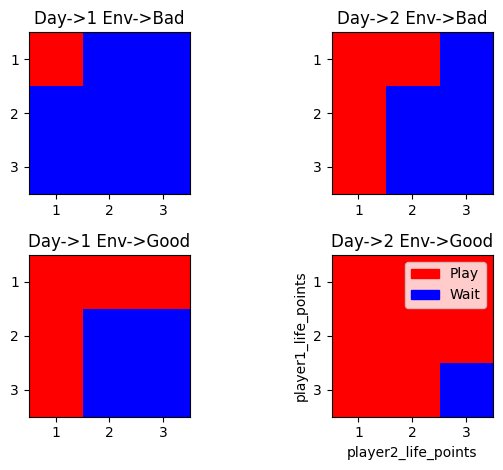

In [26]:
#@title Visualize policy
##TODO display logits instead
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

arr = df.loc[
    (df["days_left"] == 1) & 
    (df["player1_prob_payoff"] < 0.3) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & 
    (df["player1_previous_action"] == "none") & 
    (df["player2_previous_action"] == "none"), "player2_predicted_action"
].map({"wait": 0, "play": 1}).values

ax1.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
ax1.set_title("Day->1 Env->Bad")
ax1.set_xticks([0, 1, 2], [1, 2, 3])
ax1.set_yticks([0, 1, 2], [1, 2, 3])

arr = df.loc[
    (df["days_left"] == 2) & 
    (df["player1_prob_payoff"] < 0.3) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & 
    (df["player1_previous_action"] == "none") & 
    (df["player2_previous_action"] == "none"), "player2_predicted_action"
].map({"wait": 0, "play": 1}).values

ax2.imshow(np.reshape(arr, (3, 3)), cmap='bwr', vmin=0, vmax=1)
ax2.set_title("Day->2 Env->Bad")
ax2.set_xticks([0, 1, 2], [1, 2, 3])
ax2.set_yticks([0, 1, 2], [1, 2, 3])

arr = df.loc[
    (df["days_left"] == 1) & 
    (df["player1_prob_payoff"] > 0.3) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & 
    (df["player1_previous_action"] == "none") & 
    (df["player2_previous_action"] == "none"), "player2_predicted_action"
].map({"wait": 0, "play": 1}).values

ax3.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
ax3.set_title("Day->1 Env->Good")
ax3.set_xticks([0, 1, 2], [1, 2, 3])
ax3.set_yticks([0, 1, 2], [1, 2, 3])

arr = df.loc[
    (df["days_left"] == 2) & 
    (df["player1_prob_payoff"] > 0.3) & 
    (df["player1_life_points"] > 0.5) & 
    (df["player2_life_points"] > 0.5) & 
    (df["player1_previous_action"] == "none") & 
    (df["player2_previous_action"] == "none"), "player2_predicted_action"
].map({"wait": 0, "play": 1}).values

ax = ax4.imshow(np.reshape(arr, (3, 3)), cmap='bwr', vmin=0, vmax=1)
ax4.set_title("Day->2 Env->Good")
ax4.set_xticks([0, 1, 2], [1, 2, 3])
ax4.set_yticks([0, 1, 2], [1, 2, 3])
ax4.set_xlabel("player2_life_points")
ax4.set_ylabel("player1_life_points")

red_patch = mpatches.Patch(color='red', label='Play')
blue_patch = mpatches.Patch(color='blue', label='Wait')

plt.legend(handles=[red_patch, blue_patch])

fig.tight_layout()
plt.show()

death rate (in %) of player1: 31.5 +- 6.815
death rate (in %) of player2: 19.6 +- 5.888


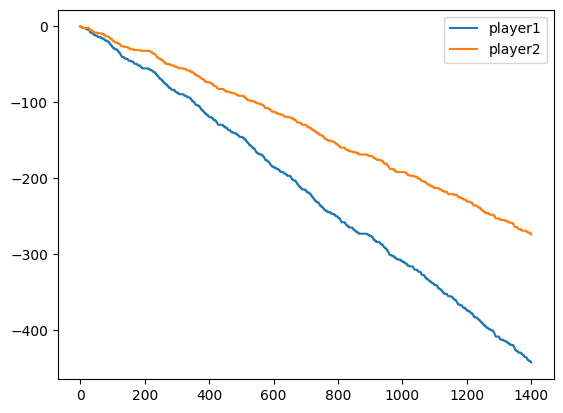

In [30]:
#@title Case - optimal vs optimal
policy = MultiAgentPolicyManager([OptimalPolicy(), OptimalPolicy()],  _get_env_test())
test_envs = DummyVectorEnv([_get_env_test for _ in range(2)])
test_collector = Collector(policy, test_envs, exploration_noise=True)

result = test_collector.collect(n_step=4*1000)
arr = result["rews"]
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()